In [19]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List

%matplotlib notebook

# Problem 2

Units are:
- Distance: 100 Parsecs
- Time: 

and we assume $G = M = 1$ so $r_s \approx 10^{-7}$.
\begin{align*}
\frac{d^2\mathbf{r}_{BH}}{dt^2} &= -\frac{GM_{BH}}{4r^3_{BH}}\mathbf{r}_{BH} + \dot{\mathbf{v}}_{DF} \\
\dot{\mathbf{v}}_{DF} &= -\frac{A}{v^3_{BH} + B}\mathbf{v}_{BH} \\
\mathbf{r}_0 &= (1,0) \\
\mathbf{v}_0 &= 0.8 \mathbf{v}_{circ} \implies v_0 = \frac{2}{5\sqrt{r_0}} \\
\hat{\mathbf{v}}_0 &= R(-\pi/2)\hat{\mathbf{r}}_0 = \frac{1}{r_0}(y_0, -x_0) \\
\mathbf{v}_0 &= \frac{2}{5r_0^{3/2}}(y_0, -x_0)
\end{align*}
Then for $x(t+2h) = x_2$ and $x(t+h) = x_1$ both obtained by RK4, we have that the next optimal step size is
$$h' = h\rho^{1/4}$$
where
$$\rho = \frac{h\delta}{\lVert\boldsymbol{\epsilon}\rVert} = \frac{30h\delta}{\lVert\mathbf{r}_1 - \mathbf{r}_2\rVert}$$
and
$$\boldsymbol{\epsilon} = (\epsilon_x, \epsilon_y) = \frac{1}{30}(|x_1 - x_2|, |y_1 - y_2|)$$
If $\rho < 1$ update $h$ and redo that step. If $\rho >= 1$ then keep the value obtained from two steps of $h$ and now update $h$ and continue.

In [607]:
def rk4_step(f: Callable, r: np.array, t: float, h: float, **kwargs):
    k1 = h*f(r, t, **kwargs)
    k2 = h*f(r + 0.5*k1, t + 0.5*h, **kwargs)
    k3 = h*f(r + 0.5*k2, t + 0.5*h, **kwargs)
    k4 = h*f(r + k3, t + h, **kwargs)
    return r + (k1 + 2*k2 + 2*k3 + k4)/6

In [321]:
def get_rho(r1: np.array, r2: np.array, h: float, delta: float):
    pos1 = r1[:2]
    pos2 = r2[:2]
    if (pos1 == pos2).all():
        return 1
    return 30*h*delta / np.linalg.norm(pos1 - pos2)

In [322]:
# r = x, y, vx, vy
def f_no_fric(r: np.array, t: float):
    pos = r[:2]
    v = r[2:4]
    return np.hstack([v, -1 * pos / (4 * np.linalg.norm(pos)**3)])

In [323]:
def f_fric(r: np.array, t: float, A=1, B=1):
    pos = r[:2]
    v = r[2:4]
    dv = -1*A*v / (pow(np.linalg.norm(v), 3) + B)
    return f_no_fric(r, t) + np.hstack([np.zeros(2), dv])

In [608]:
def adaptive_RK4(f: Callable, r0: np.array, t0: float, h0: float, total_time: float = None,
                 stop_at: float = None, delta=1e-8, A=1, B=1):
    if total_time is None and stop_at is None:
        total_time = h0
    elif total_time is None:
        total_time = np.inf
    results = [r0]
    times = [t0]
    cur_time = t0
    r = r0
    h = h0
    while cur_time < total_time + t0:
        r1_half = rk4_step(f, r, cur_time, h, A=A, B=B)
        r1 = rk4_step(f, r1_half, cur_time + h, h, A=A, B=B)
        r2 = rk4_step(f, r, cur_time, 2*h, A=A, B=B)
        rho = get_rho(r1, r2, h, delta)
        rho = rho if rho <= 16 else 16 # limit h to grow by a factor of 2 or less
        if rho >= 1:
            results.append(r1_half)
            results.append(r1)
            times.append(cur_time + h)
            times.append(cur_time + 2*h)
            cur_time += 2*h
            r = r1
            if stop_at is not None:
                distance = np.linalg.norm(r[:2])
                if distance < stop_at or abs((distance - stop_at)/stop_at) < 0.05:
                    break
        h *= pow(rho, 1/4)
    return np.vstack(results), times

## part (b)

In [572]:
# For the initial conditions
x0 = 1
y0 = 0
v0 = 2/5
mag_pos = np.sqrt(x0**2 + y0**2)
r0 = np.array([x0, y0, v0*y0/mag_pos, -v0*x0/mag_pos])
r0

array([ 1. ,  0. ,  0. , -0.4])

## part (c)

In [ ]:
a_vals = np.linspace(0.5, 10, 10)
b_vals = np.linspace(0.5, 10, 10)
aa, bb = np.meshgrid(a_vals, b_vals)

tt = np.zeros(aa.shape)

for i in range(10):
    for j in range(10):
        _, times = adaptive_RK4(f_fric, r0, 0, T/10, total_time=None, stop_at=1e-7, delta=1e-8,
                                A=aa[i,j], B=bb[i,j])
        tt[i,j] = times[-1]

In [668]:
tt = 1.492*tt

In [669]:
flipper = np.zeros((6, 6))
for i in range(6):
    flipper[5-i, i] = 1
    
tt2 = np.matmul(flipper, tt[:6])

### Most of the Values of the Ratio B/A are

<IPython.core.display.Javascript object>


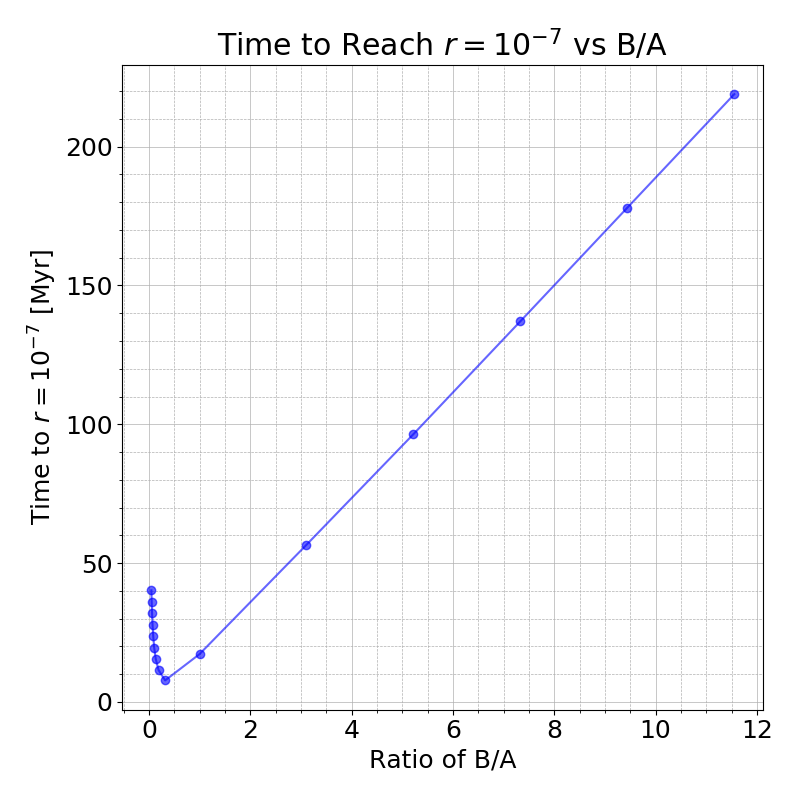

In [693]:
BA1 = 0.5/a_vals
BA2 = b_vals[:6]/0.5
times_BA1 = tt[0]
times_BA2 = tt[:6, 0]

BA = np.hstack([np.array(list(reversed(BA1))), BA2[1:]])
times_BA = np.hstack([np.array(list(reversed(times_BA1))), times_BA2[1:]])

fig = plt.figure()
fig.set_size_inches(8,8)
ax = fig.add_subplot()
ax.plot(BA, times_BA, '-o', alpha=0.6, c='blue')

ax.set_xlabel("Ratio of B/A")
ax.set_ylabel("Time to $r = 10^{-7}$ [Myr]")
ax.set_title("Time to Reach $r = 10^{-7}$ vs B/A")
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(True, which='major', linestyle='-', linewidth='0.5')
ax.grid(True, which='minor', linestyle='--', linewidth='0.5')
fig.tight_layout()
fig.savefig("prob2_time_vs_ba.png")

## part (d)

<IPython.core.display.Javascript object>


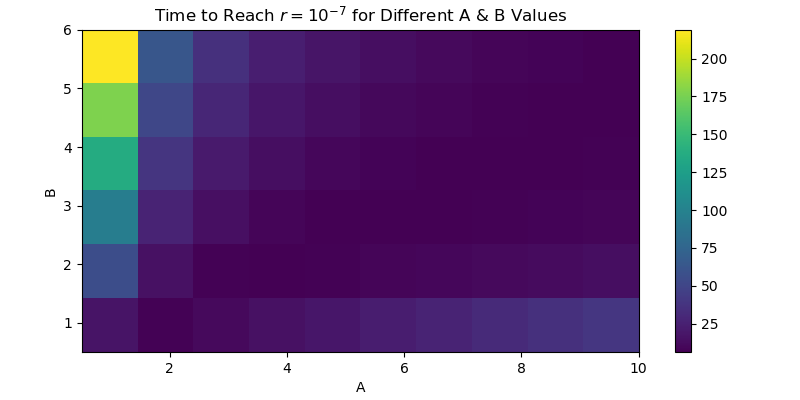

In [671]:
fig = plt.figure()
fig.set_size_inches(8,4)
ax = fig.add_subplot()
im = ax.imshow(tt2, extent=[0.5, 10, 0.5, 6])
fig.colorbar(im, shrink=1)

#ax.minorticks_on()
#ax.set_xticks(np.arange(1, 10))
#ax.set_yticks(np.arange(0.5, 6))
ax.set_xlabel("A")
ax.set_ylabel("B")
ax.set_title("Time to Reach $r = 10^{-7}$ for Different A & B Values")
fig.tight_layout()
fig.savefig("prob2_c_ab_vals.png")